#### Student Name: Mai Ngo
#### Student Email: mngo@depaul.edu
#### Group 10
#### Course Name and Number: DSC 672 Data Science Capstone
#### Date: 10/31/2024

**Purpose of this this notebook:** Consolidate one final data and clustering for listings.

In [4]:
#Mount my Google Drive.
from google.colab import drive
drive.mount("/content/drive")
import os
directory = '/content/drive/My Drive/DSC 672'
os.chdir(directory)

#Ensure the files are there (in the folder).
!pwd

Mounted at /content/drive
/content/drive/My Drive/DSC 672


In [5]:
import pandas as pd
import numpy as np
import time

#Text pre-process.
!pip install -q spacy
!pip install -q nltk
import spacy
from spacy.tokens import Span
import re
import ast
import nltk
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
from collections import Counter
from datetime import timedelta

#Clustering.
!pip install -q matplotlib
!pip install -q scipy
!pip install -q scikit-learn
!pip install -q wordcloud
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

#Word cloud.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

#CTA data location.
!pip install -q geopy
from geopy.distance import geodesic

#For warnings.
import warnings
warnings.filterwarnings("ignore")

# **Load data.**

In [ ]:
reviews = pd.read_csv("reviews_final2.csv")
print (f"Reviews dataset shape: {reviews.shape}")
reviews.head(2)

Reviews dataset shape: (403291, 9)


,listing_id,id,date,comments,comments_lemmatized,vader_compound_score,VADER_sentiment,VADER_sentiment_label,SVC_sentiment
0,2384,25218143,1/9/2015,it's a wonderful trip experience. I didn't exc...,"['wonderful', 'trip', 'experience', 'except', ...",0.9489,positive,1,1
1,2384,28475392,3/24/2015,This is my first trip using Airbnb. I was a li...,"['first', 'trip', 'using', 'little', 'nervous'...",0.9519,positive,1,1


In [ ]:
listings = pd.read_csv("listings_final.csv")
print (f"Listings dataset shape: {listings.shape}")
listings.head(2)

Listings dataset shape: (7952, 18)


,id,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,availability_365,review_scores_accuracy,reviews_count,name_description,log_price
0,16757056,t,t,Lower West Side,41.84656,-87.68345,Entire home/apt,5,1.0,2.0,3.0,"[""Shampoo"", ""Dedicated workspace"", ""Wifi"", ""Pr...",103.0,105,4.88,205,Heart of Chicago 2BD + Parking Comfortably fit...,4.644391
1,48112045,f,f,West Town,41.89479,-87.69336,Entire home/apt,6,1.0,2.0,2.0,"[""Shampoo"", ""Dining table"", ""Window AC unit"", ...",169.0,84,4.72,66,West Town Chicago Apt near Metra and United Ce...,5.135798


## **Preliminary observation.**
*   Reviews dataset only contains reviews of 6,476 listings.
*   There is 7,952 listing total -> Assigned mean sentiment score for 'leftover' listings.


In [ ]:
reviews['listing_id'].nunique()

6476

# **Merge data based on listings id.**

## **First: Sentiment Calculation.**

In [ ]:
reviews = reviews.drop(columns=['VADER_sentiment_label'])
#Merge both dataset first -- reviews: 'listing_id' and listings:'id'.
mergedData = listings.merge(reviews, left_on='id', right_on='listing_id', how='left')
#Drop unnecessary columns.
mergedData = mergedData.drop(columns=['listing_id', 'id_y', 'comments', 'comments_lemmatized'])
mergedData.rename(columns = {'id_x':'listing_id'}, inplace = True)
mergedData.rename(columns = {'vader_compound_score':'VADER_compound_score'}, inplace = True)
#Ensure 'date' column is in datetime format.
mergedData['date'] = pd.to_datetime(mergedData['date'])
#Find the latest review date for each listing.
latest_reviewDates = mergedData.groupby('listing_id')['date'].max().reset_index()
latest_reviewDates.rename(columns={'date': 'latest_review_date'}, inplace=True)
#Merge latest review dates with the main data.
mergedData = mergedData.merge(latest_reviewDates, on='listing_id', how='left')
#Calculate days difference from the latest review date for each review.
mergedData['days_since_latest'] = (mergedData['latest_review_date'] - mergedData['date']).dt.days

In [ ]:
def timeWeight(days):
  '''Function apply weight based on the days since the latest review date of a listing.'''
  if pd.notna(days):
    if days <= 90:
      return 1.0
    elif 91 <= days <= 365:
      return 0.9
    else:
      return 0.85
  else:
    return np.nan

In [ ]:
#Apply weight to each row based on 'days_since_latest'
mergedData['weight'] = mergedData['days_since_latest'].apply(timeWeight)
#Calculate weighted sentiment scores for each listing.
mergedData['weighted_VADER_score'] = mergedData['VADER_compound_score'] * mergedData['weight']
mergedData['weighted_SVC_score'] = mergedData['SVC_sentiment'] * mergedData['weight']

In [ ]:
#Group by 'listing_id' and calculate the weighted average for each sentiment-related column.
mergedData2 = mergedData.groupby('listing_id').agg(
    avgWeighted_VADER=('weighted_VADER_score', 'sum'),
    totalWeight=('weight', 'sum'),
    avgWeighted_SVC=('weighted_SVC_score', 'sum')).reset_index()

#Final weighted average.
mergedData2['avgWeighted_VADER'] /= mergedData2['totalWeight']
mergedData2['avgWeighted_SVC'] /= mergedData2['totalWeight']
mergedData2 = mergedData2.drop(columns=['totalWeight'])

In [ ]:
#Calculate the mean of each sentiment column to fill in missing values.
meanVADER_score = mergedData2['avgWeighted_VADER'].mean()
#meanVADER_sentiment = mergedData2['avg_VADER_sentiment'].mean()
meanSVC_score = mergedData2['avgWeighted_SVC'].mean()

print (f"Average VADER compound score: {meanVADER_score}")
#print (f"Average VADER sentiment score: {meanVADER_sentiment}")
print (f"Average SVC sentiment score: {meanSVC_score}")

Average VADER compound score: 0.7862683804426105
Average SVC sentiment score: 0.9022131699321478


In [ ]:
#Fill any missing values in the aggregated averages with the overall means.
mergedData2['avgWeighted_VADER'] = mergedData2['avgWeighted_VADER'].fillna(meanVADER_score)
mergedData2['avgWeighted_SVC'] = mergedData2['avgWeighted_SVC'].fillna(meanSVC_score)

## **Second: Join with listings data.**
*   We're done with reviews data at this point. Moving forward with joint listings data (has aggregated sentiment score of each listings).



In [ ]:
#Merge both dataset first -- listings:'id' and mergedData2: 'listing_id'
listings2 = listings.merge(mergedData2, left_on='id', right_on='listing_id', how='left')
listings2 = listings2.drop(columns=['listing_id', 'log_price', 'review_scores_accuracy'])
print (f"Dataset shape: {listings2.shape}")

Dataset shape: (7952, 18)


In [ ]:
#Double check for missing values in sentiment score.
missingValues = listings2[['avgWeighted_VADER', 'avgWeighted_SVC']].isnull().any()
print("Missing values in avgWeighted_VADER:", missingValues['avgWeighted_VADER'])
print("Missing values in avgWeighted_SVC:", missingValues['avgWeighted_SVC'])

Missing values in avgWeighted_VADER: False
Missing values in avgWeighted_SVC: False


In [ ]:
#Check for missing values in the entire listings2.
missingValues = listings2.isnull().sum()
print("Columns with missing values in listings2:")
print(missingValues[missingValues > 0])

Columns with missing values in listings2:
host_is_superhost    190
bathrooms            355
bedrooms              87
beds                 403
price                354
dtype: int64


### **Fill in missing values.**
*   host_is_superhost: randomly replace with 50-50 false and true. Since the inherent distribution is not significantly skewed.
*   bathrooms, bedrooms, beds: Taking the average then round down -> Would rather give undercount of accommodations then over. Ideally, we don't want guests to not have enough space.
*   price: replace with the average.




In [ ]:
#Distribution of the 'host_is_superhost' column.
superhostDistribution = listings2['host_is_superhost'].value_counts()
print(f"Distribution of the 'host_is_superhost' column: {superhostDistribution}")

Distribution of the 'host_is_superhost' column: host_is_superhost
f    4196
t    3566
Name: count, dtype: int64


In [ ]:
#'host_is_superhost'
superhost_randomFill = np.random.choice([True, False], size=listings2['host_is_superhost'].isnull().sum())
listings2.loc[listings2['host_is_superhost'].isnull(), 'host_is_superhost'] = superhost_randomFill

#'bathrooms', 'bedrooms', and 'beds'
listings2['bathrooms'] = listings2['bathrooms'].fillna(np.floor(listings2['bathrooms'].mean()))
listings2['bedrooms'] = listings2['bedrooms'].fillna(np.floor(listings2['bedrooms'].mean()))
listings2['beds'] = listings2['beds'].fillna(np.floor(listings2['beds'].mean()))

#'price'.
listings2['price'] = listings2['price'].fillna(np.ceil(listings2['price'].mean()).astype(float))

#Double check for missing values in the entire listings2.
missingValues = listings2.isnull().sum()
print("Columns with missing values in listings2:")
print(missingValues[missingValues > 0])

Columns with missing values in listings2:
Series([], dtype: int64)


## **Plot sentiment score distribution.**

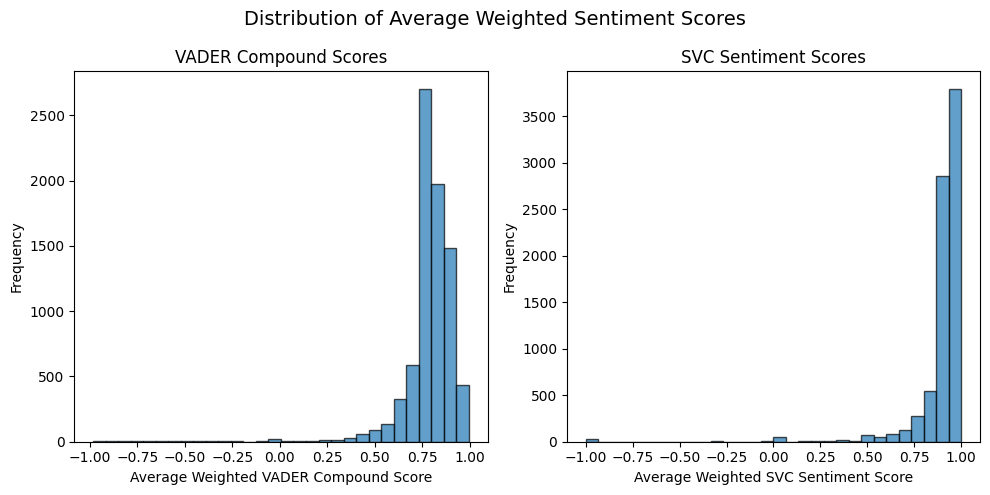

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot distribution of avgWeighted_VADER
axes[0].hist(listings2['avgWeighted_VADER'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("VADER Compound Scores")
axes[0].set_xlabel("Average Weighted VADER Compound Score")
axes[0].set_ylabel("Frequency")

# Plot distribution of avgWeighted_SVC
axes[1].hist(listings2['avgWeighted_SVC'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("SVC Sentiment Scores")
axes[1].set_xlabel("Average Weighted SVC Sentiment Score")
axes[1].set_ylabel("Frequency")
fig.suptitle("Distribution of Average Weighted Sentiment Scores", fontsize=14)
# Display the plots with adjusted layout
plt.tight_layout()
plt.show()

# **Description of listings - Text analysis.**

In [ ]:
listings3 = listings2.copy()

In [ ]:
def processText(text):
  '''Tokenize text function using Spacy's default stop words.'''

  #Lowering all text.
  text = re.sub(r'[^\w\s]', '', text.lower())

  #Filter out tokens.
  filteredTokens = []

  for token_text in nlp(text):
    #Get tokens that are alpha, and not stop words.
    if token_text.text.isalpha() and token_text.text not in nlp.Defaults.stop_words:
      #Token length has to be more than 2.
      if 2 < len(token_text) < 19:
        filteredTokens.append(str(token_text))
  return filteredTokens

## **Tokenize listings description.**

In [ ]:
startTime = time.time()
listings3['tokens'] = listings3['name_description'].apply(processText)
endTime = time.time()
print (f"Run time: {endTime - startTime}")
listings3['tokens'] = listings3['tokens'].apply(lambda tokens: [str(i) for i in tokens])
#Duplicate 'tokens' column and rename it to 'short_tokens'.
listings3['short_tokens'] = listings3['tokens']

Run time: 156.46760320663452


## **Lemmatization.**

In [ ]:
def lemmatizeTokens(tokens):
  '''Lemmatize tokens using Spacy.'''
  return [token.lemma_ for token in nlp(" ".join(tokens))]

startTime = time.time()
listings3['short_tokens'] = listings3['short_tokens'].apply(lemmatizeTokens)
endTime = time.time()
print (f"Run time: {endTime - startTime}")

Run time: 106.37111783027649


# **Clustering listings.**
*   Objective: Grouping listings with common words/characteristics in description.
*   For each list of tokens in the 'short_tokens' column, aka. each observation, calculate a mean embedding - use length 50. Clustering using Hierarchical Clustering - based on the similarity of their embeddings.



## **Create embeddings.**

In [ ]:
def loadGlove(vectorLen=50):
  '''Function load 50-dimensional GloVe embeddings.'''

  #Vector_len must be 50/100/200/300.
  GloVe = f"glove.6B.{vectorLen}d.txt"

  #Dictionary stores embeddings of all words.
  embeddings_dict = {}

  with open(GloVe, 'r', encoding="utf-8") as f:
    for line in f:
      values = line.split()
      word = str(values[0])

      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

gloveEmbeddings = loadGlove(50)

In [ ]:
def remove_customWords(data, column, wordList):
  '''Function to remove specific words from a list of tokens.'''

  data[column] = data[column].apply(lambda tokens: [word for word in tokens if word not in wordList])
  return data

#These are common words that I decided to exclude to bring out the characteristics of each cluster.
wordList = ['chicago', 'nan', 'room', 'home', 'place', 'neighborhood', 'bedroom', 'airbnb', 'locate', 'miles', 'mile', 'apartment', 'walk', 'park',
            'loop', 'city', 'downtown', 'restaurant', 'minute', 'line', 'stay', 'area', 'offer', 'away', 'street', 'location', 'michigan', 'min',
            'close', 'block']
listings3 = remove_customWords(listings3, 'short_tokens', wordList)

In [ ]:
def meanEmbedding(tokens, embeddingsDict, embeddingDim=50):
  '''Function to compute mean embedding of a list of words.'''
  embeddings = [embeddingsDict[word] for word in tokens if word in embeddingsDict]
  if embeddings:
    return np.mean(embeddings, axis=0)
  else:
    #Return a zero vector if no embeddings are found.
    return np.zeros(embeddingDim)

listings3['embedding'] = listings3['short_tokens'].apply(lambda tokens: meanEmbedding(tokens, gloveEmbeddings))
#Stack all embeddings to create the embeddings matrix.
embeddingsMatrix = np.vstack(listings3['embedding'].values)

## **Hierarchical Clustering.**
*   Have tried Kmeans and DBSCAN but the output were too 'general'.



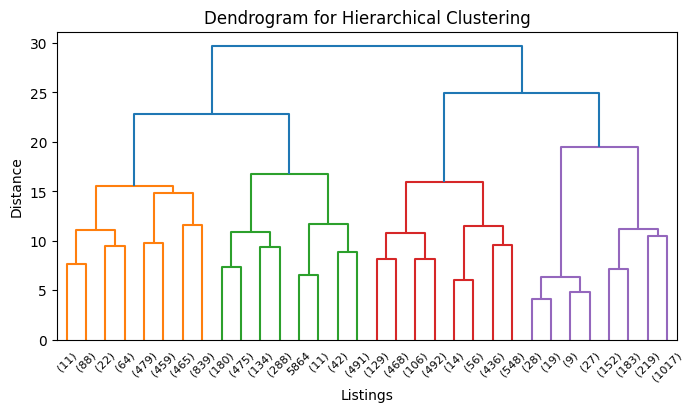

hierarchical_cluster
0    4049
2    2249
1    1654
Name: count, dtype: int64


In [ ]:
#Create a linkage matrix for the dendrogram.
linkageMatrix = linkage(embeddingsMatrix, method='ward')

#Dendrogram.
plt.figure(figsize=(8, 4))
dendrogram(linkageMatrix, truncate_mode='level', p=4)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Listings")
plt.ylabel("Distance")
plt.show()

#Apply Agglomerative Clustering.
numClusters = 3
aggCluster = AgglomerativeClustering(n_clusters=numClusters, metric='euclidean', linkage='ward')
listings3['hierarchical_cluster'] = aggCluster.fit_predict(embeddingsMatrix)
print(listings3['hierarchical_cluster'].value_counts())

## **Word Cloud Cluster.**
*   There are three clusters given the first one has the most observations. Interestingly, clusters output strongly highlight neighborhood preference.
*   1st cluster's Word Cloud encompasses more of River North area, where majority of Airbnbs + tourists prefer to stay.
*   2nd cluster's Word Cloud entails more of tourist activities and area wise, South Loop area downward - Museum Campus.
*   3rd cluster's Word Cloud is for more laid back, less tourist activities.
*   Initially, I was not planning to have the clusters based on locations, more of characteristics. But the pattern makes sense since dominantly, people visits Chicago for tourism so locaion would be a crucial factor here.


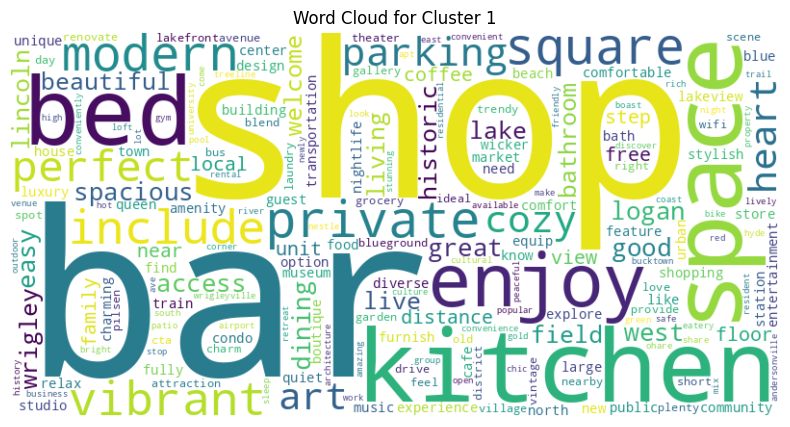

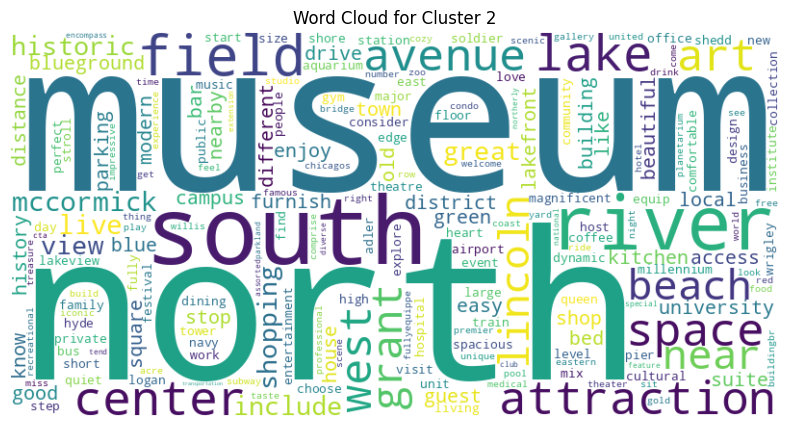

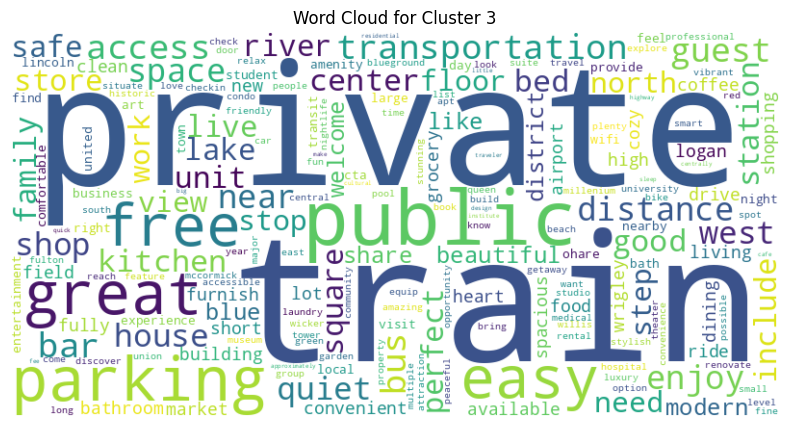

In [ ]:
def clusterWordcloud(data, clusterLabel):
  '''Generate a word cloud for a specific cluster.'''
  #Filter tokens for the given cluster.
  clusterTokens = data[data['hierarchical_cluster'] == clusterLabel]['short_tokens'].explode()
  wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(clusterTokens.value_counts())

  plt.figure(figsize=(10, 5))
  plt.title(f"Word Cloud for Cluster {clusterLabel+1}")
  plt.imshow(wordCloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

numClusters = listings3['hierarchical_cluster'].nunique()
for clusterLabel in range(numClusters):
  clusterWordcloud(listings3, clusterLabel)

## **Naming clusters.**
*   Using clusters as a cross-check initial recommendation.
*   Cluster 1: "Vibrant Social Spaces" – focused on socializing and modern amenities.
*   Cluster 2: "Cultural and Scenic Attractions" – centered around museums, rivers, and scenic locations.
*   Cluster 3: "Accessible with Public Transportation" – highlights easy access to transit options and convenience for travelers.
*   Tried BERTtopic but the output did not make sense.



In [ ]:
#Dictionary for top words of each cluster.
clusterDict = {}
for clusterID in range(3):
  clusterTokens = listings3[listings3['hierarchical_cluster'] == clusterID]['short_tokens'].explode()
  wordCounts = Counter(clusterTokens)
  clusterDict[clusterID] = wordCounts.most_common(10)

for clusterID, topWords in clusterDict.items():
  print(f"\nTop 10 words for Cluster {clusterID + 1}:")
  for word, count in topWords:
    print(f"{word}: {count}")


Top 10 words for Cluster 1:
bar: 1617
shop: 1547
kitchen: 1439
space: 1376
bed: 1241
enjoy: 1229
private: 1210
square: 1186
modern: 1139
vibrant: 1066

Top 10 words for Cluster 2:
museum: 1119
north: 1089
south: 1039
river: 1016
field: 992
lake: 740
center: 714
attraction: 670
space: 662
avenue: 638

Top 10 words for Cluster 3:
train: 960
private: 866
public: 818
parking: 812
great: 781
easy: 734
free: 730
transportation: 713
bus: 706
bar: 690


### **Mapping name.**

In [ ]:
clusterNames = {0: "Vibrant Social Spaces", 1: "Cultural and Scenic Attractions", 2: "Accessible with Public Transportation"}
listings3['cluster_name'] = listings3['hierarchical_cluster'].map(clusterNames)

# **Train Station data.**

In [ ]:
cta = pd.read_csv("cta_final.csv")
print (f"Reviews dataset shape: {cta.shape}")

Reviews dataset shape: (145, 3)


## **Get Stations that are closed to each listing.**

In [ ]:
def find_nearbyStations(listingLat, listingLon):
  '''Find nearby train stations using existing 'station_info' column.
  Rule: < 10 minutes walking distance -> 0.8 Kilometers.'''
  nearbyStations = []
  for _, row in cta.iterrows():
    stationInfo = row['station_info']
    stationLat = row['latitude']
    stationLon = row['longitude']

    #Calculate distance using geopy -- in kilometers.
    distanceKM = geodesic((listingLat, listingLon), (stationLat, stationLon)).kilometers
    #If within 0.8 KM (about 10-minute walk), add to the list.
    if distanceKM <= 0.8:
      nearbyStations.append((stationInfo, (stationLat, stationLon)))
  return nearbyStations

startTime = time.time()
listings3['train_station'] = listings3.apply(lambda row: find_nearbyStations(row['latitude'], row['longitude']), axis=1)
endTime = time.time()
print (f"Run time: {endTime - startTime}")

Run time: 289.76453948020935


In [ ]:
#Drop  unnecessary columns.
listings3 = listings3.drop(columns=['hierarchical_cluster', 'reviews_count', 'tokens','availability_365', 'avgWeighted_SVC'])
#Rename some columns.
listings3.rename(columns = {'short_tokens':'tokens'}, inplace = True)

# **Write sentiment output to a csv file.**
*   This is the data for recommender system.



In [ ]:
listings3.to_csv('final_data.csv', index=False)

**Export this notebook to a pdf file.**

In [6]:
!apt-get -qq install -y pandoc > /dev/null 2>&1
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert --to pdf "/content/drive/MyDrive/DSC 672/DSC672 - Listing Clustering.ipynb" > /dev/null 2>&1

[NbConvertApp] Converting notebook /content/drive/MyDrive/DSC 672/DSC672 - Listing Clustering.ipynb to pdf
[NbConvertApp] Support files will be in DSC672 - Listing Clustering_files/
[NbConvertApp] Making directory ./DSC672 - Listing Clustering_files
[NbConvertApp] Writing 84152 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 960563 bytes to /content/drive/MyDrive/DSC 672/DSC672 - Listing Clustering.pdf
